# Exploratory Data Analysis

This notebook explores the data through Pandas and visualization tools.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import folium
import json

In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
raw_path = path + '/data/raw/'
processed_path = path + '/data/processed/'

In [3]:
# Read in the dataset from the csv.
df_uber = pd.read_csv(processed_path + 'uber.csv')

# Change the 'date' column datatype to date/time
df_uber.date = pd.to_datetime(df_uber.date)

In [4]:
df_uber.head()

,sourceid,dstid,mean_travel_time,time_of_week,date,trip
0,191,46,2021.00,weekdays,2016-02-01,191-46
1,168,42,1528.99,weekdays,2016-02-01,168-42
2,203,3,836.38,weekdays,2016-03-01,203-3
3,192,36,1752.46,weekdays,2016-02-01,192-36
4,218,8,1118.07,weekdays,2016-02-01,218-8


In [5]:
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2868168 entries, 0 to 2868167
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   sourceid          int64         
 1   dstid             int64         
 2   mean_travel_time  float64       
 3   time_of_week      object        
 4   date              datetime64[ns]
 5   trip              object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 131.3+ MB


## Visualizing Time Series data

In [6]:
# Subset the dataframe for visualization.

# Weekday Trips
df_wd = df_uber[df_uber['time_of_week'] != 'weekends']

# Weekend Trips
df_we = df_uber[df_uber['time_of_week'] != 'weekdays']

In [7]:
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440174 entries, 0 to 2779524
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   sourceid          1440174 non-null  int64         
 1   dstid             1440174 non-null  int64         
 2   mean_travel_time  1440174 non-null  float64       
 3   time_of_week      1440174 non-null  object        
 4   date              1440174 non-null  datetime64[ns]
 5   trip              1440174 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 76.9+ MB


In [8]:
df_we.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1427994 entries, 84067 to 2868167
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   sourceid          1427994 non-null  int64         
 1   dstid             1427994 non-null  int64         
 2   mean_travel_time  1427994 non-null  float64       
 3   time_of_week      1427994 non-null  object        
 4   date              1427994 non-null  datetime64[ns]
 5   trip              1427994 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 76.3+ MB


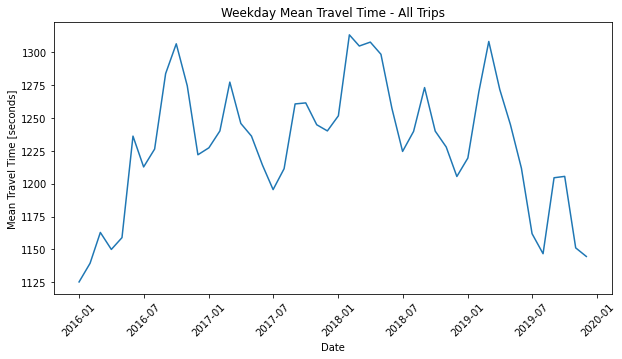

In [9]:
# Generate a plot for the Weekday Trips.

# Only the date and mean_travel_time are needed.
df_wd_ts = df_wd[['date', 'mean_travel_time']]

# Using 'groupby' sets the date as the index.
df_wd_ts = df_wd_ts.groupby('date').mean()

# Create the plot.
plt.figure(figsize=(10,5))
plt.title('Weekday Mean Travel Time - All Trips')
plt.xlabel('Date')
plt.ylabel('Mean Travel Time [seconds]')
plt.plot(np.array(df_wd_ts.index), df_wd_ts.mean_travel_time)

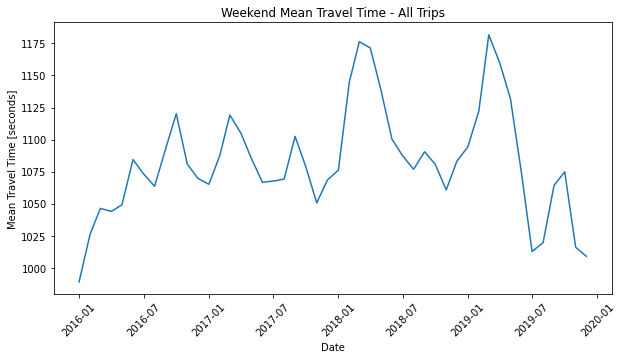

In [10]:
# Generate a plot for the Weekend Trips.

# Only the date and mean_travel_time are needed.
df_we_ts = df_we[['date', 'mean_travel_time']]

# Using 'groupby' sets the date as the index.
df_we_ts = df_we_ts.groupby('date').mean()

# Create the plot.
plt.figure(figsize=(10,5))
plt.title('Weekend Mean Travel Time - All Trips')
plt.xlabel('Date')
plt.ylabel('Mean Travel Time [seconds]')
plt.plot(np.array(df_we_ts.index), df_we_ts.mean_travel_time)

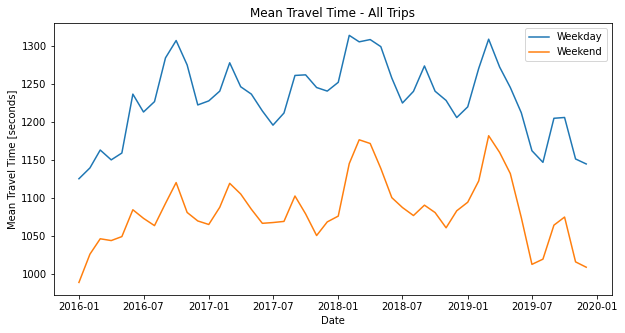

In [11]:
# Create a plot to compare Weekday and Weekend Trips.
plt.figure(figsize=(10,5))
plt.title('Mean Travel Time - All Trips')
plt.xlabel('Date')
plt.ylabel('Mean Travel Time [seconds]')
plt.plot(np.array(df_wd_ts.index), df_wd_ts.mean_travel_time, label='Weekday')
plt.plot(np.array(df_we_ts.index), df_we_ts.mean_travel_time, label='Weekend')
plt.legend()
plt.savefig(path + '/images/ts.png')

## Average Travel Time

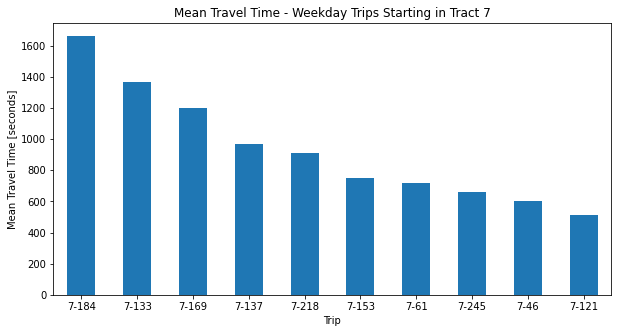

In [82]:
# Create a barplot to view a random selection of Weekday Trips starting in tract 7.
df = df_wd[df_wd['sourceid']==7]
df = df.groupby(['trip'])['mean_travel_time'].mean().reset_index()
df.set_index('trip', inplace=True)

df = df.sample(n=10)
df.sort_values('mean_travel_time', ascending=False, inplace=True)

df.plot.bar(figsize=(10,5), legend=None)
plt.title('Mean Travel Time - Weekday Trips Starting in Tract 7')
plt.xlabel('Trip')
plt.ylabel('Mean Travel Time [seconds]')
plt.xticks(rotation=0)
plt.savefig(path + '/images/bar.png')

In [88]:
select_trips = df.index.tolist()
select_trips

['7-184',
 '7-133',
 '7-169',
 '7-137',
 '7-218',
 '7-153',
 '7-61',
 '7-245',
 '7-46',
 '7-121']

## Seasonal Decomposition

Default, or 12 month, seasonality.

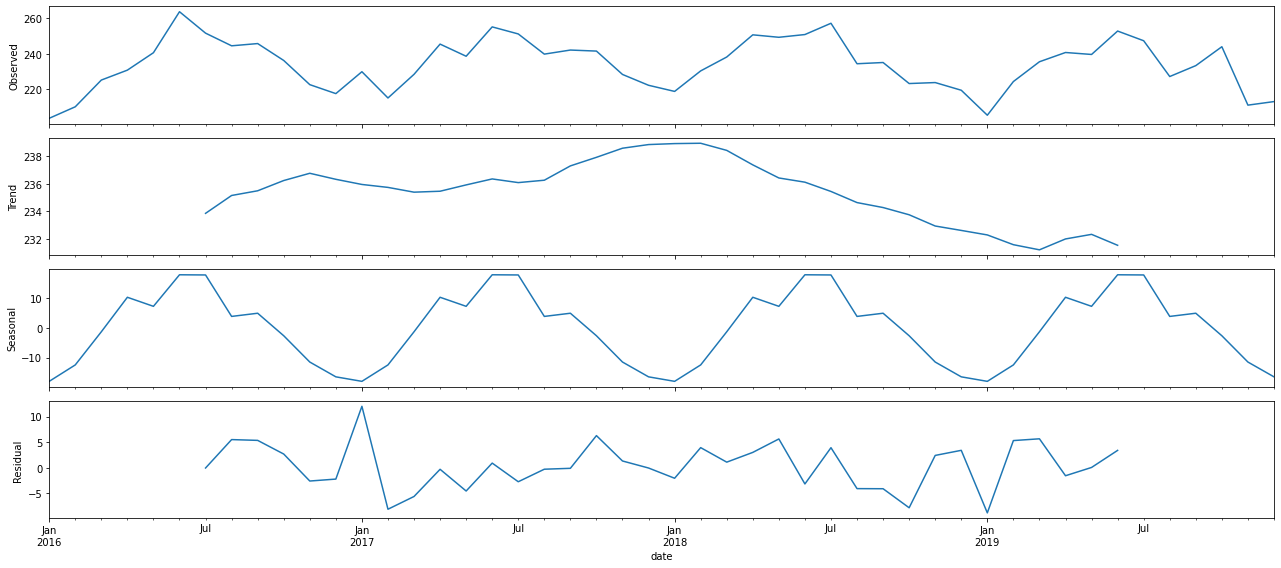

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_wd_ts.mean_travel_time, model='additive')
fig = decomposition.plot()
plt.show()
fig.savefig(path + '/images/decompose.png')

## Visualizing the Tracts in the json file

In [ ]:
# Load the json file containing the Uber tract geometry.
with open(raw_path + "washington_DC_censustracts.json") as f:
    tracts = json.load(f)

# Create a Folium map centered on Washington DC at latitude 38.9072° N and longitude 77.0369° W.
m = folium.Map(location = [38.9072,-77.0369], tiles='Stamen Toner', zoom_start = 12)

# Loop through "tracts" and plot each of the coordinates.
for i in range(0, len(tracts['features'])):
    for j in range(0, len(tracts['features'][i]['geometry']['coordinates'])):
        for k in range(0, len(tracts['features'][i]['geometry']['coordinates'][j])):
            for l in range(0, len(tracts['features'][i]['geometry']['coordinates'][j][k])):
                longitude = tracts['features'][i]['geometry']['coordinates'][j][k][l][0]
                latitude = tracts['features'][i]['geometry']['coordinates'][j][k][l][1]
                folium.CircleMarker([latitude, longitude], radius = 1, color='red').add_to(m)
# Show the map
m